# 数据绘图要点5-误差线的问题

误差线给出了测量精确度的一般概念，真实（无误差）值可能与报告值相差多远。如果条形图上显示的值是聚合的结果（如多个数据点的平均值），您可能需要显示误差线。但我们必须要谨慎使用误差线，具体原因将在后续给出。

## 误差线的绘制

在下图中，报告了5个group。条形高度代表它们的平均值。黑色误差线提供有关单个观测值如何分散在平均值周围的信息。例如，似乎groupB中的测量结果比groupE中的更精确。

In [7]:
# 加载库
library(tidyverse)
library(hrbrthemes)
library(viridis)
library(patchwork)

# 创建数据
data <- data.frame(
    # 创建小写数字
    name=letters[1:5],
    value=sample(seq(4,15),5),
    sd=c(1,0.2,3,2,4)
)

# 展示数据
head(data)

,name,value,sd
,<fct>,<int>,<dbl>
1,a,10,1.0
2,b,5,0.2
3,c,12,3.0
4,d,9,2.0
5,e,7,4.0


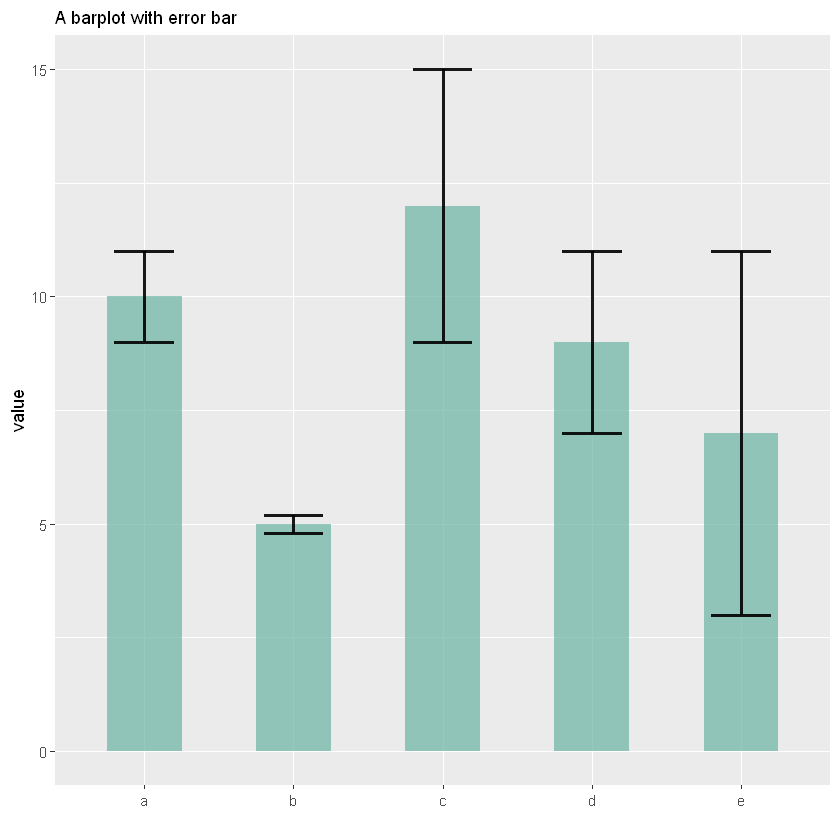

In [8]:
# 绘图
ggplot(data) +
# 绘制条形
geom_bar( aes(x=name, y=value), stat="identity", fill="#69b3a2", alpha=0.7, width=0.5) +
# 绘制误差线
geom_errorbar( aes(x=name, ymin=value-sd, ymax=value+sd), width=0.4, colour="black", alpha=0.9, size=1) +
theme(
  legend.position="none",
  plot.title = element_text(size=11)
) +
ggtitle("A barplot with error bar") +
xlab("")

## 误差线中的问题
### 误差线隐藏信息

误差线可能会隐藏很多信息。如下图所示，这是PLOS Biology期刊一篇论文[Beyond Bar and Line Graphs: Time for a New Data Presentation Paradigm](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002128)中的图。它说明完整的数据可能暗示与汇总统计数据不同的结论。其中A图是一张用于汇总数据带有误差线的条形图。但是从A图中，我们并不能得到A图中两个数据组明确的数据分布信息，因为A图可能对应不同数据组分布信息。A可能会对应B，C，D，E四张图，而这四张图表示了完全不同的数据分布信息。B图表示两个数据组具有相同类型的数据分布，C图表示第二个数据组有异常值，D图表示两组数据分布不同，E图表示两组数据样本数不同。

![](image/img5_1.png)


因此，带有误差线的相同条形图实际上可以讲述非常不同的故事，对读者来说这些数据是隐藏的。所以尽可能显示个人数据信息。

### 误差线的计算方式

误差线的第二个问题是误差线有多种计算方式，并且并不总是清楚显示的是哪一个。误差线通常使用三种不同的计算方式，选择不同的计算方式有时给出非常不同的结果。下面是它们的定义以及如何在R上计算。

**标准偏差(SD)**

表示变量的分散量。计算公式为方差的平方根

```
# 计算方差
sd <- sd(vec)
# 计算平方根
sd <- sqrt(var(vec))
```

**标准误差(SE)** 

表示变量均值的标准偏差，计算方法为SD除以样本大小的平方根。通过计算方法，SE小于SD。对于非常大的样本量，SE趋向于0。

```
se = sd(vec) / sqrt(length(vec))
```

**置信区间(CI)**

表示使某个值存在于其内的特定概率。它计算为t*SE，其中t值是t检验在特定显著水平alpha下的统计量值。其值在具有较大的样本量时通常四舍五入到1.96。但是，如果样本量很大或分布不正态，则最好使用bootstrap方法计算CI。

```
alpha=0.05
t=qt((1-alpha)/2 + .5, length(vec)-1)   
# 数据量很大是取为1.96
# t = 1.96
CI=t*se
```

以上3个指标在著名的Iris数据集上应用时。三种鸢尾花的平均萼片长度和平均长度用误差线表示的结果完全不同。



In [9]:
# 读取数据
data <- iris %>% select(Species, Sepal.Length) 
head(data)

,Species,Sepal.Length
,<fct>,<dbl>
1,setosa,5.1
2,setosa,4.9
3,setosa,4.7
4,setosa,4.6
5,setosa,5.0
6,setosa,5.4


In [10]:
# 分别计算标准偏差，标准误差，置信区间
my_sum <- data %>%
  group_by(Species) %>%
  summarise( 
    n=n(),
    mean=mean(Sepal.Length),
    sd=sd(Sepal.Length)
  ) %>%
  mutate( se=sd/sqrt(n))  %>%
  mutate( ic=se * qt((1-0.05)/2 + .5, n-1))

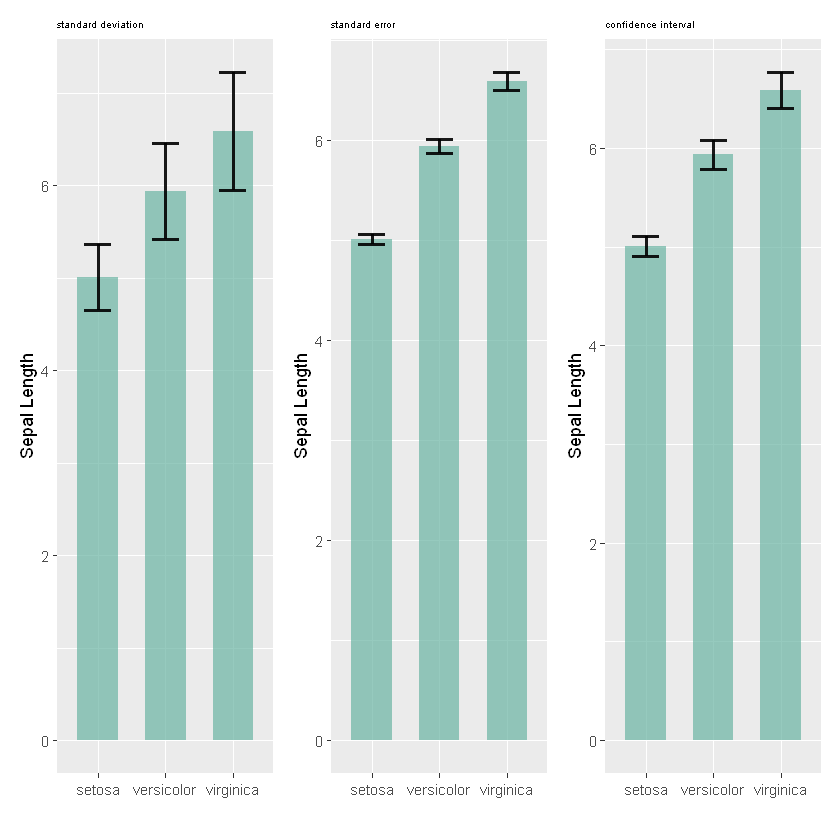

In [11]:

# 标准偏差
p1 <- ggplot(my_sum) +
  geom_bar( aes(x=Species, y=mean), stat="identity", fill="#69b3a2", alpha=0.7, width=0.6) + 
  geom_errorbar( aes(x=Species, ymin=mean-sd, ymax=mean+sd), width=0.4, colour="black", alpha=0.9, size=1) +
  ggtitle("standard deviation") +
  theme(
    plot.title = element_text(size=6)
  ) +
  xlab("") +
  ylab("Sepal Length")
 
# 标准误差
p2 <- ggplot(my_sum) +
  geom_bar( aes(x=Species, y=mean), stat="identity", fill="#69b3a2", alpha=0.7, width=0.6) + 
  geom_errorbar( aes(x=Species, ymin=mean-se, ymax=mean+se),width=0.4, colour="black", alpha=0.9, size=1) +
  ggtitle("standard error") +
  theme(
    plot.title = element_text(size=6)
  ) +
  xlab("") +
  ylab("Sepal Length")
 
# 置信区间
p3 <- ggplot(my_sum) +
  geom_bar( aes(x=Species, y=mean), stat="identity", fill="#69b3a2", alpha=0.7, width=0.6) + 
  geom_errorbar( aes(x=Species, ymin=mean-ic, ymax=mean+ic), width=0.4, colour="black", alpha=0.9, size=1) +
  ggtitle("confidence interval") +
  theme(
    plot.title = element_text(size=6)
  ) +
  xlab("") +
  ylab("Sepal Length")

p1 + p2 + p3

很明显，这 3 个指标报告了非常不同的可视化和结论。所以应该始终指定用于误差线的指标。

### 解决方法

最好尽可能避免误差线。当然，如果您只有汇总统计数据，这是不可能的。但是，如果您知道各个数据点，请显示它们。有几种解决方法是可能的。带有散点信息的箱形图适用于相对少量的数据。当数据量较多时，使用小提琴数据图是另一种办法。



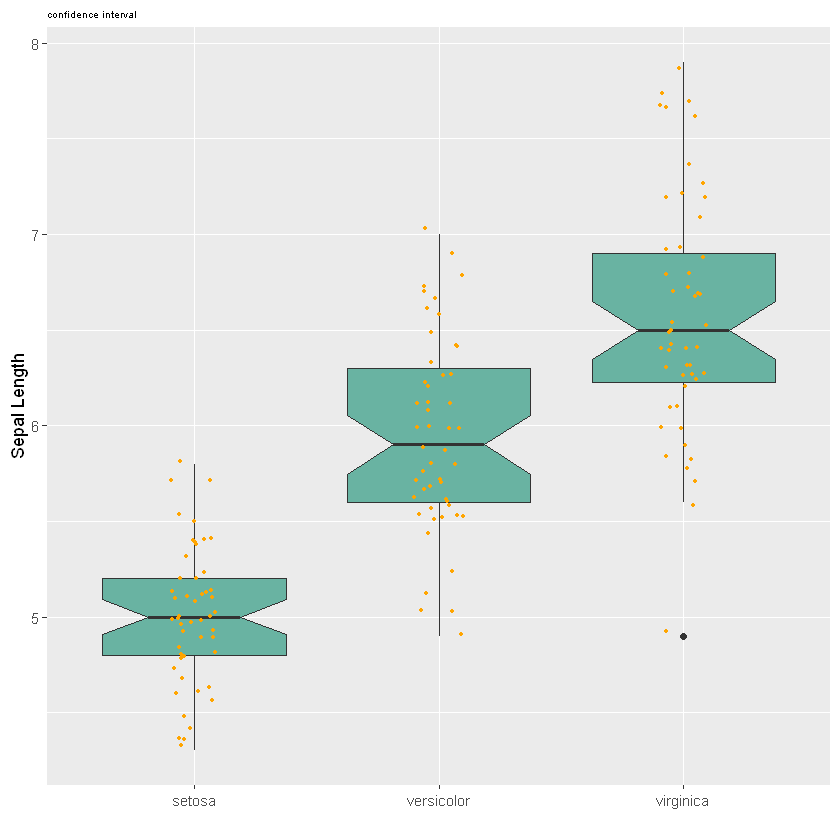

In [12]:
ggplot(data,aes(x=Species, y=Sepal.Length)) +
# 绘图,notch为TRUE表示绘制小提琴图，否则为绘制箱形图
geom_boxplot( fill="#69b3a2", notch=T) +
# 绘制数据点信息
geom_jitter( size=0.9, color="orange", width=0.1) +
ggtitle("confidence interval") +
theme(
  plot.title = element_text(size=6)
) +
xlab("") +
ylab("Sepal Length")

## 参考

+ [Beyond Bar and Line Graphs: Time for a New Data Presentation Paradigm](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002128)
+ [THE ISSUE WITH ERROR BARS](https://www.data-to-viz.com/caveat/error_bar.html)